## Library Import

In [ ]:
!pip install librosa

In [ ]:
import pandas as pd
import numpy as np

import IPython.display as ipd
import librosa

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

from google.colab import drive
drive.mount("/content/drive")

## Data Load

### Dataset Info
- id : 샘플 별 고유 ID
- path : 음향 샘플 파일 경로
- label : 감정의 종류
    - 0: angry
    - 1: fear
    - 2: sad
    - 3: disgust
    - 4: neutral
    - 5: happy

In [ ]:
!unzip -qq "/content/drive/MyDrive/Dacon/월간 데이콘 음성 감정 인식 AI 경진대회/data/open.zip"

In [ ]:
test = pd.read_csv("/content/open/test.csv")
train = pd.read_csv("/content/open/train.csv")

In [ ]:
train.head()

,id,path,label
0,TRAIN_0000,./train/TRAIN_0000.wav,1
1,TRAIN_0001,./train/TRAIN_0001.wav,2
2,TRAIN_0002,./train/TRAIN_0002.wav,4
3,TRAIN_0003,./train/TRAIN_0003.wav,5
4,TRAIN_0004,./train/TRAIN_0004.wav,4


In [ ]:
train.tail()

,id,path,label
4996,TRAIN_4996,./train/TRAIN_4996.wav,5
4997,TRAIN_4997,./train/TRAIN_4997.wav,0
4998,TRAIN_4998,./train/TRAIN_4998.wav,1
4999,TRAIN_4999,./train/TRAIN_4999.wav,1
5000,TRAIN_5000,./train/TRAIN_5000.wav,4


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5001 non-null   object
 1   path    5001 non-null   object
 2   label   5001 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


## EDA

In [ ]:
train.label.value_counts()

0    867
2    859
5    853
3    852
1    848
4    722
Name: label, dtype: int64

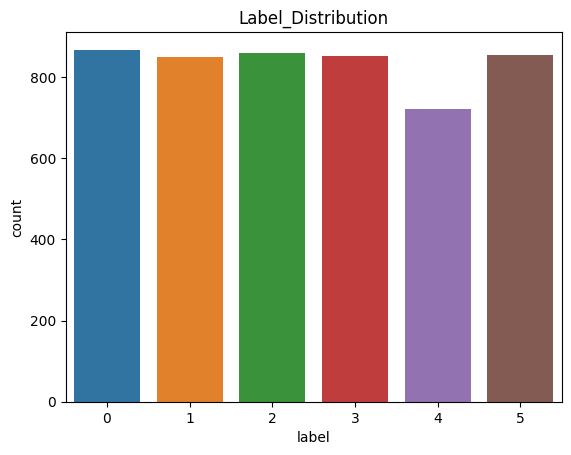

In [ ]:
plt.title("Label_Distribution")
sns.countplot(x = train.label)
plt.show()

In [ ]:
train.loc[train["length"] == train["length"].min()]

KeyError: ignored

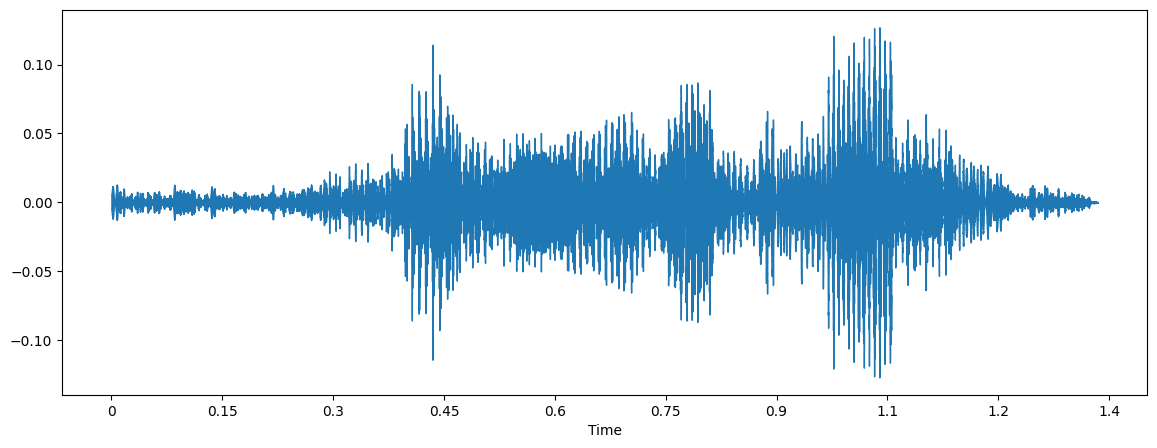

In [ ]:
x, sr = librosa.load('/content/open/train/TRAIN_3197.wav')
display(ipd.Audio(x, rate=sr))
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)
plt.show()

In [ ]:
mfcc = librosa.feature.mfcc(x, sr, n_mfcc=100, n_fft=400, hop_length=160)

TypeError: ignored

### Audio Length

In [ ]:
train["length"] = 0
test["length"] = 0

In [ ]:
for idx, data in tqdm(enumerate(train["id"])):
    x, sr = librosa.load('/content/open/train/' + data + '.wav')
    train["length"][idx] = (len(x)/sr)
print("Done")

5001it [00:16, 309.46it/s]

Done


In [ ]:
for idx, data in tqdm(enumerate(test["id"])):
    x, sr = librosa.load('/content/open/test/' + data + '.wav')
    test["length"][idx] = (len(x)/sr)
print("Done")

1881it [00:03, 572.61it/s]

Done


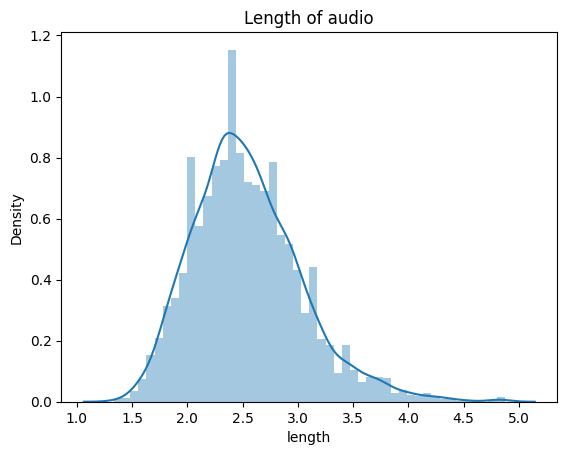

In [ ]:
# len_list로 정규분포 확인
plt.title("Length of audio")
sns.distplot(train['length'])
plt.show()

In [ ]:
train.groupby("label")["length"].mean()

label
0    2.603650
1    2.524656
2    2.588892
3    2.773880
4    2.425500
5    2.320147
Name: length, dtype: float64

In [ ]:
train.head()

,id,path,label,length
0,TRAIN_0000,./train/TRAIN_0000.wav,1,2.369025
1,TRAIN_0001,./train/TRAIN_0001.wav,2,2.602630
2,TRAIN_0002,./train/TRAIN_0002.wav,4,2.902902
3,TRAIN_0003,./train/TRAIN_0003.wav,5,2.302313
4,TRAIN_0004,./train/TRAIN_0004.wav,4,1.868571


In [ ]:
test.head()

,id,path,length
0,TEST_0000,./test/TEST_0000.wav,2.402404
1,TEST_0001,./test/TEST_0001.wav,2.602630
2,TEST_0002,./test/TEST_0002.wav,2.736100
3,TEST_0003,./test/TEST_0003.wav,2.702721
4,TEST_0004,./test/TEST_0004.wav,1.868526


## Preprocess

### 1. 단순 푸리에 변환 → Spectrum

Text(0.5, 1.0, 'Power spectrum')

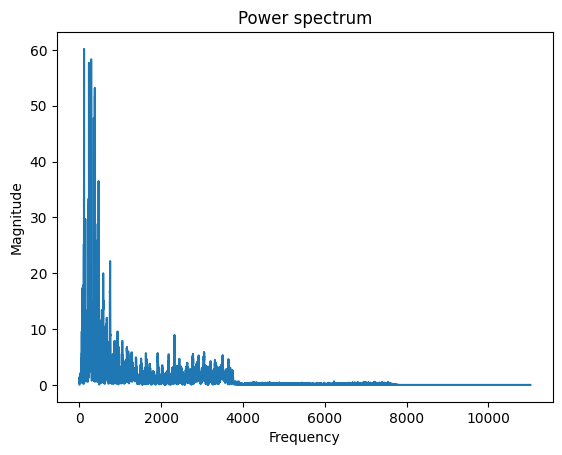

In [ ]:
# 푸리에 변환
fft = np.fft.fft(x)

# 복소공간 값 절댓갑 취해서, magnitude 구하기
magnitude = np.abs(fft)

# Frequency 값 만들기
f = np.linspace(0,sr,len(magnitude))

# 푸리에 변환을 통과한 specturm은 대칭구조로 나와서 high frequency 부분 절반을 날려고 앞쪽 절반만 사용한다.
left_spectrum = magnitude[:int(len(magnitude)/2)]
left_f = f[:int(len(magnitude)/2)]
plt.plot(left_f, left_spectrum)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

### 2. STFT → Spectrogram
- 조용한 라이브러리나 침실: 약 30-40 dB
- 일반적인 대화 소음: 약 50-60 dB
- 시끄러운 도로 교통 소음: 약 70-80 dB
- 공연이나 음악 공간 소음: 80 dB 이상

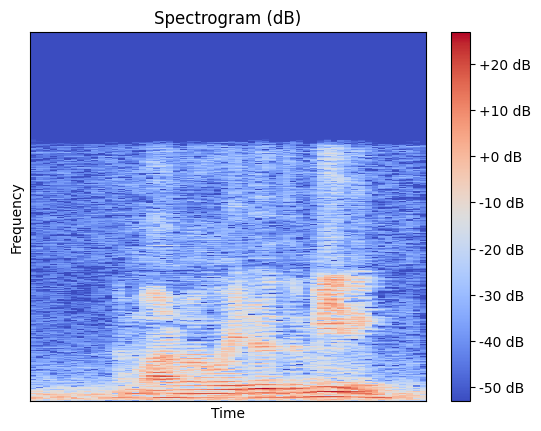

In [ ]:
# STFT -> spectrogram
hop_length = 512  # 전체 frame 수
n_fft = 2048  # frame 하나당 sample 수

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sr
n_fft_duration = float(n_fft)/sr

# STFT
stft = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)

# 복소공간 값 절댓값 취하기
magnitude = np.abs(stft)

# magnitude > Decibels 
log_spectrogram = librosa.amplitude_to_db(magnitude)

# display spectrogram
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")
plt.show()

### 3. MFCC

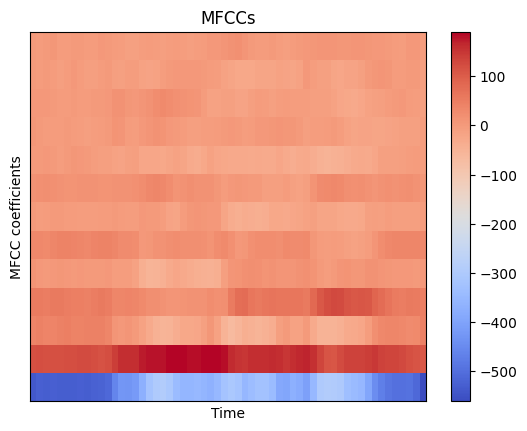

In [ ]:
# MFCCs
# extract 13 MFCCs
MFCCs = librosa.feature.mfcc(y= x, sr = sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# display MFCCs
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()

In [ ]:
import random

In [ ]:
def audio_visual():
    data = random.randint(0, len(train))
    print(data)
    print('/content/open/train/TRAIN_' + str(data) + '.wav')
    x, sr = librosa.load('/content/open/train/TRAIN_' + str(data) + '.wav')
    display(ipd.Audio(x, rate=sr))
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(x, sr=sr)
    plt.show()